In [1]:
import pandas as pd #manejo de datos.
from nltk.probability import FreqDist #gráficos de frecuencia.
import matplotlib.pyplot as plt #mostrar figuras.
from wordcloud import WordCloud #nube de palabras.
from dateutil.parser import parse #analizar strings de fechas.
import numpy as np #manejo numérico.
from nltk.tokenize import RegexpTokenizer #separación por expresiones regulares.
from nltk.corpus import stopwords #lista de stopwords.
from nltk.stem.porter import PorterStemmer #obtener raíz de una palabra.
from sklearn.feature_extraction.text import CountVectorizer #contador de palabras.
from sklearn.model_selection import train_test_split #partición dataset.
from sklearn.linear_model import LogisticRegression #regresión logística.
from sklearn.metrics import accuracy_score #evaluación del clasificador.

from os import path

In [2]:
SAVE_DATAFRAME = False
SAVE_FIG = True
PROCESAR = False

PATH_MAIN = path.join("..")
PATH_DATA = path.join(PATH_MAIN, "datos")
PATH_IMG = path.join(PATH_MAIN, "imagenes")

PATH_FAKE = path.join(PATH_DATA, "Fake.csv")
PATH_FAKE_TEXT = path.join(PATH_DATA, "fake_text.txt")
PATH_TRUE = path.join(PATH_DATA, "True.csv")
PATH_TRUE_TEXT = path.join(PATH_DATA, "true_text.txt")

## Lectura de datos

**Eliminar corchetes en df_true y df_fake para considerar todo el dataset.**

In [3]:
#lectura de noticias:
df_true = pd.read_csv(PATH_TRUE)[1:100]
df_fake = pd.read_csv(PATH_FAKE)[1:100]

#agregar columna de clasificación:
df_true['true'] = 1
df_fake['true'] = 0

#unificar:
df_news = pd.concat([df_true,df_fake], ignore_index = True)

## Visualización de datos

### Etiquetas

In [4]:
def cardinal_etiquetas(df, kind):
    print(f'\nETIQUETAS DE NOTICIAS {kind}:')
    for etiqueta in pd.unique(df.subject):
        cantidad = len(df[df.subject == etiqueta])
        print(f'{etiqueta}: {cantidad} datos.')


cardinal_etiquetas(df_true, 'VERDADERAS')
cardinal_etiquetas(df_fake, 'FALSAS')


ETIQUETAS DE NOTICIAS VERDADERAS:
politicsNews: 99 datos.

ETIQUETAS DE NOTICIAS FALSAS:
News: 99 datos.


### Frecuencia de palabras

NOTICIAS VERDADERAS
- Frecuencia por title:


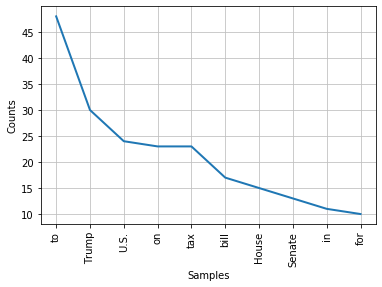

- Frecuencia por text:


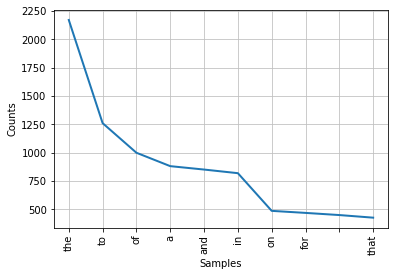

NOTICIAS FALSAS
- Frecuencia por title:


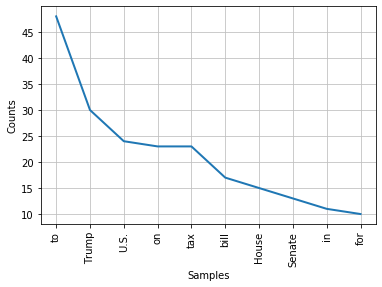

- Frecuencia por text:


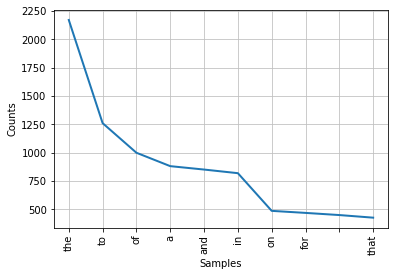

TODAS LAS NOTICIAS
- Frecuencia por title:


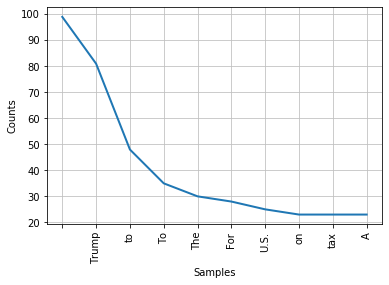

- Frecuencia por text:


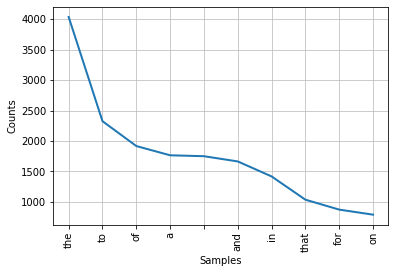

In [5]:
def word_frequency(data, n):
    for col in ['title', 'text']:
        word_array = []
        for row in data[col]:
            for word in row.split(' '):
                word_array.append(word)
        print(f'- Frecuencia por {col}:')
        FreqDist(word_array).plot(n)


print('NOTICIAS VERDADERAS')
word_frequency(df_true, 10)

print('NOTICIAS FALSAS')
word_frequency(df_true, 10)

print('TODAS LAS NOTICIAS')
word_frequency(df_news, 10)

### Nube de palabras

Nube para noticias verdaderas:


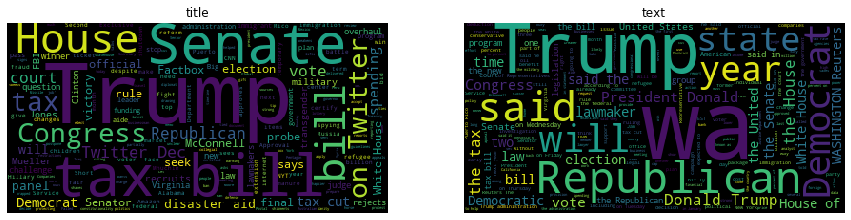

Nube para noticias falsas:


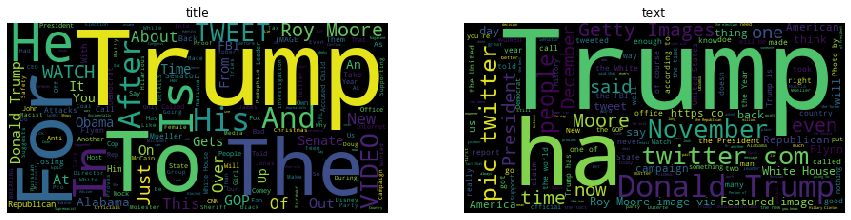

In [6]:
def show_wordcloud(data):
    fig, axs = plt.subplots(1, 2, figsize=(15, 15))
    for idx, col in enumerate(['title', 'text']):
        full_text = ''.join([str(text) + ' ' for text in data[col]])
        wordcloud = WordCloud().generate(full_text)
        axs[idx].imshow(wordcloud)
        axs[idx].set_title(col)
        axs[idx].axis('off')
    plt.show()


print('Nube para noticias verdaderas:')
show_wordcloud(df_true)

print('Nube para noticias falsas:')
show_wordcloud(df_fake)

## Limpieza de datos

### Corrección de fechas

Hay noticias cuya entrada *date* no tiene la estructura de fecha por lo que se deben eliminar ya que a priori no se puede garantizar que no exista correlación entre la fecha de publicación de la noticia y su veracidad.

Para esto, se verificará en cada noticia si su entrada *date* tiene estructura de fecha válida y en el caso de que no, se sustituirá por un valor NaN para luego eliminar la noticia completa mediante el método *dropna* aplicado sobre el DataFrame.

In [7]:
def fix_date(date):
    try:
        parse(str(date))
        return pd.Timestamp(date)
    except:
        return np.nan


df_news['date'] = df_news['date'].apply(fix_date).dropna()

### Limpieza de texto

Para poder comparar los elementos de cada noticia es necesario depurar el texto, eliminando símbolos y palabras irrelevantes en el sentido de la información. Además, mediante *PorterStemmer().stem* se conservarán solo los lexemas de cada palabra ya que se asumirá que las conjugaciones y/o derivaciones de estos no aportan información a la clasificación. Si bien esto último no es necesariamente cierto, la reducción de dimensionalidad que proporciona el stemming permite evitar el sobreajuste al considerar cada una de las palabras como un objeto distinto.

In [8]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')


def clean_df(df, col):
    clean_col = []
    for news_item in df[col]:
        clean_text = []
        for word in tokenizer.tokenize(news_item):
            if word not in set(stopwords.words("english")):
                clean_text.append(PorterStemmer().stem(word))
        clean_col.append(' '.join(clean_text))
    return clean_col


for col in ['title', 'text']:
    df_news[col] = clean_df(df_news, col)

In [9]:
df_news.head()

,title,text,subject,date,true
0,U .s. militari accept transgend recruit monday...,washington (reuters) - transgend peopl allow f...,politicsNews,2017-12-29,1
1,senior U .s. republican senat : 'let Mr . muel...,washington (reuters) - the special counsel inv...,politicsNews,2017-12-31,1
2,fbi russia probe help australian diplomat tip ...,washington (reuters) - trump campaign advis ge...,politicsNews,2017-12-30,1
3,trump want postal servic charg 'much ' amazon ...,seattl /washington (reuters) - presid donald t...,politicsNews,2017-12-29,1
4,"white hous , congress prepar talk spend , immigr","west palm beach , fla ./washington (reuters) -...",politicsNews,2017-12-29,1


## Clasificación

### Selección de características

Con el texto tokenizado, se formará un conjunto de $k$ variables que representará a cada una de las palabras (distintas) presentes en el conjunto de noticias (cada palabra será una característica). Dicha asociación palabra-variable puede encontrarse en **vectorizer.get_feature_names()** donde el orden de las palabras corresponde a su variable asociada.

Luego, se transformará cada noticia en un vector de $\mathbb{N_0}^k$ donde la $i$-ésima entrada corresponderá a la cantidad de apariciones de la $i$-ésima en la noticia. De este modo, se tiene una única matriz (**encoded_data**) que almacenará cada una de las noticias, lo cual permitirá realizar regresión logística para obtener el clasificador buscado.

Lo único que falta definir es de qué modo se van a entregar los elementos de cada noticia (título y cuerpo). Se proponen las siguientes opciones:

1. Entregar solo los títulos.
2. Entregar solo los cuerpos (contenido).
3. Entregar título y cuerpo como una única cadena (concatenada).

In [10]:
def data_encoding(data):
    vectorizer = CountVectorizer()
    # matriz de características.
    encoded_data = vectorizer.fit_transform(data).toarray()
    print('Características totales:', str(len(vectorizer.get_feature_names())))

    print('Características promedio por noticia:')
    print('- Poderado:',
          np.round(np.mean([sum(news_item) for news_item in encoded_data]), 2))
    print('- Simple:',
          np.round(np.mean([np.count_nonzero(news_item) for news_item in encoded_data]), 2))
    return encoded_data

# ejemplos de entrega de data:


x = [None]*3

print('\nSOLO TÍTULOS')
x[0] = data_encoding(df_news['title'])

print('\nSOLO CUERPO')
x[1] = data_encoding(df_news['text'])

print('\nTITULOS Y CUERPO')
x[2] = data_encoding(
    [news_item for news_item in df_news['title'] + ' ' + df_news['text']])


SOLO TÍTULOS
Características totales: 962
Características promedio por noticia:
- Poderado: 10.63
- Simple: 10.52

SOLO CUERPO
Características totales: 6759
Características promedio por noticia:
- Poderado: 261.11
- Simple: 172.12

TITULOS Y CUERPO
Características totales: 6820
Características promedio por noticia:
- Poderado: 271.74
- Simple: 175.81


### Entrenamiento y evaluación

Una vez codificada la información en forma matricial, se realizará regresión logística sobre las 3 codificaciones expuestas y se compararán sus características más directas.

Para el entrenamiento del modelo logístico se particionará el dataset utilizando un 70% para entrenamiento y 30% para validación.

Por último, se evaluarán los clasificadores dentro y fuera de muestra (de acuerdo a la partición anterior). Para esto, se mostrará la probabilidad de acierto media (correspondiente a la media de las probabilidades de haber clasificado correctamente) y el puntaje de precisión, definido como el cociente entre predicciones correctas y el número total de datos).

In [11]:
# clasificación real:
y = list(df_news['true'])


def classification(x):

    # partición del conjunto:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

    print('\nTotal de datos:', len(y))
    print('- Datos de entrenamiento:', len(y_train))
    print('- Datos de validación:', len(y_test))

    # clasificación:
    classifier = LogisticRegression()
    classifier.fit(x_train, y_train)

    def classifier_evaluation(x_eval, y_eval):

        # predicciones y probabilidades de acierto para x_eval:
        y_pred = classifier.predict(x_eval)
        y_prob = classifier.predict_proba(x_eval)*100
        print(
            f'- Precisión (fracción): {np.round(accuracy_score(y_eval, y_pred)*100,2)}%')
        print(
            f'- Probabilidad de acierto media: {str(np.round(np.mean([max(prob) for prob in y_prob]),2))}%')

    print('\nEvaluación dentro de muestra:')
    classifier_evaluation(x_train, y_train)

    print('\nEvaluación fuera de muestra:')
    classifier_evaluation(x_test, y_test)


print('\nSOLO TÍTULOS')
classification(x[0])
print('\nSOLO CUERPO')
classification(x[1])
print('\nTITULOS Y CUERPO')
classification(x[2])


SOLO TÍTULOS

Total de datos: 198
- Datos de entrenamiento: 138
- Datos de validación: 60

Evaluación dentro de muestra:
- Precisión (fracción): 100.0%
- Probabilidad de acierto media: 91.2%

Evaluación fuera de muestra:
- Precisión (fracción): 95.0%
- Probabilidad de acierto media: 82.72%

SOLO CUERPO

Total de datos: 198
- Datos de entrenamiento: 138
- Datos de validación: 60

Evaluación dentro de muestra:
- Precisión (fracción): 100.0%
- Probabilidad de acierto media: 99.54%

Evaluación fuera de muestra:
- Precisión (fracción): 98.33%
- Probabilidad de acierto media: 95.75%

TITULOS Y CUERPO

Total de datos: 198
- Datos de entrenamiento: 138
- Datos de validación: 60

Evaluación dentro de muestra:
- Precisión (fracción): 100.0%
- Probabilidad de acierto media: 99.59%

Evaluación fuera de muestra:
- Precisión (fracción): 98.33%
- Probabilidad de acierto media: 93.16%


Se observa una mayor precisión en el caso de que solo se entregue el cuerpo (y no además el título) de la noticia mientras que se observa una mayor confianza en la predicción cuando se entrega tanto el título como el cuerpo.